This code allows balls tracking in fly pushing experiments.

For now, proved successful in single corridor arenas with 1 fly and 1 ball, with different arena materials.

# Libraries

In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

# add path to utilities module
import sys
sys.path.insert(0, "..")


from Utilities.Utils import *
from Utilities.Processing import *

import black
import jupyter_black

jupyter_black.load()

# Path definition

In [ ]:
VideoPath = Path(
    "/mnt/labserver/DURRIEU_Matthias/Experimental_data/Optogenetics/Optobot/MultiMaze_15stepped_gated_bowtie/Starved_noWater/230209/111026_s0a0_p0-0/Arena5/Arena5.mp4"
)

In [ ]:
# Mac path
VideoPath = Path(
    '/Volumes/Ramdya-Lab/DURRIEU_Matthias/Experimental_data/Optogenetics/Optobot/MultiMazeBiS_15_Steel_Wax/Female_Starved_noWater/221116/102044_s0a0_p6-0/Arena4/Arena4.mp4'
)


In [3]:
# AltPath
VideoPath = Path(
    "/Volumes/Transfert_H/Feb2023/MultiMaze_15stepped_gated_bar_noFood/Starved_noWater/230209/095735_s0a0_p0-0/Arena3/Arena3.mp4"
)

## Quickly check first frame

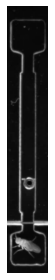

In [4]:
%matplotlib inline

vidcap = cv2.VideoCapture(VideoPath.as_posix())
for i in range(1):
    success, im_full = vidcap.read()

im_full_gray = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)

# hv.Image(im_full_gray)

plt.figure()
plt.axis("off")
plt.tight_layout()
plt.imshow(
    im_full_gray, cmap="gray", vmin=0, vmax=255
);  # semicolon removes print of matplotlib object

# Optional : Fine tune tracking parameters for new videos

## Generate trimmed version of the video

In [ ]:
# Choose the start and finish timestamps
startpoint = "00:10:20"

finishpoint = "00:10:50"
TrimmedPath = VideoPath.with_stem(VideoPath.stem + "_Trimmed")

In [ ]:
os.system(  # Ffmpeg +
    "ffmpeg -hide_banner -loglevel error -i "
    + VideoPath.as_posix()
    + " -ss "
    + startpoint
    + " -to "
    + finishpoint
    + " -c copy "
    + TrimmedPath.as_posix()
)

In [5]:
startpoint = "00:35:00"

finishpoint = "00:35:30"
TrimmedPath2 = VideoPath.with_stem(VideoPath.stem + "_Trimmed2")

In [ ]:
os.system(  # Ffmpeg +
    "ffmpeg -hide_banner -loglevel error -i "
    + VideoPath.as_posix()
    + " -ss "
    + startpoint
    + " -to "
    + finishpoint
    + " -c copy "
    + TrimmedPath2.as_posix()
)

In [8]:
startpoint = "00:00:15"

finishpoint = "00:00:50"
TrimmedPath3 = VideoPath.with_stem(VideoPath.stem + "_Trimmed3")
os.system(  # Ffmpeg +
    "ffmpeg -hide_banner -loglevel error -i "
    + VideoPath.as_posix()
    + " -ss "
    + startpoint
    + " -to "
    + finishpoint
    + " -c copy "
    + TrimmedPath3.as_posix()
)

0

In [95]:
## Play with y cropping parameters to center ROI on corridor without chambers

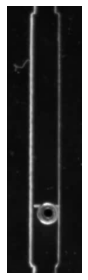

In [6]:
%matplotlib inline

cropping_parameters = (195, 655)
cropped = im_full_gray[cropping_parameters[0] : cropping_parameters[1], :]
# Note that this is arbitrary but shouldn't move from one arena to the other.
# 120:650 was chosen for previous videos, here 155:685 is better aligned with arenas
plt.axis("off")
plt.tight_layout()
plt.imshow(cropped, cmap="gray", vmin=0, vmax=255);

old method

In [ ]:
## Save cropping parameters in a file for further use
# if VideoPath.parent.joinpath("Cropping_params.npy").exists() is True:
#     choice = input("File already exists! Overwrite? [y/n]")

#     if choice == "n":
#         print("File unchanged.")

#     elif choice == "y":
#         np.save(
#             VideoPath.parent.joinpath("Cropping_params.npy").as_posix(),
#             cropping_parameters,
#         )
#         print("File updated.")

#     else:
#         print("invalid input")

# else:
#     np.save(
#         VideoPath.parent.joinpath("Cropping_params.npy").as_posix(), cropping_parameters
#     )

New method

In [ ]:
checksave(
    path=VideoPath.parent.joinpath("Cropping_params.npy"),
    object="parameter",
    file=cropping_parameters,
)

## Load cropping parameters

In [ ]:
if cropping_parameters in locals():
    pass
else:
    cropping_parameters = np.load(
        VideoPath.parent.joinpath("Cropping_params.npy").as_posix()
    )

## Check ball tracking on video sample

In [ ]:
Vidcap = cv2.VideoCapture(TrimmedPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0
ballpos = []


# Hough circles parameters to tune
param1 = 120
param2 = 50
minrad = 5
maxrad = 20
dp = 1.5
mindist = 500

# Counter for failed detections
fails = 0

while True:
    ret, frame = Vidcap.read()  # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
        cropped = im_full_gray[cropping_parameters[0] : cropping_parameters[1], :]

        # filtered = cv2.medianBlur(cropped, 5)
        filtered = cv2.GaussianBlur(cropped, (9, 9), 0)

        # rows = filt.shape[0]
        circles = cv2.HoughCircles(
            filtered,
            cv2.HOUGH_GRADIENT,
            dp=dp,
            minDist=mindist,
            param1=param1,
            param2=param2,
            minRadius=minrad,
            maxRadius=maxrad,
        )

        out = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])

                ballpos.append(center)

                # circle center
                cv2.circle(out, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                cv2.circle(out, center, radius, (255, 0, 255), 3)
        elif len(ballpos) > 0:
            fails += 1
            ballpos.append(ballpos[-1])
            cv2.circle(out, ballpos[-1], 1, (0, 0, 255), 3)
            cv2.circle(out, center, radius, (0, 0, 255), 3)

        # if len(ballpos) > 1:
        #     if np.absolute(ballpos[-1][1] - ballpos[-2][1]) > 25:
        #         ballpos_corr.append(ballpos[-2])
        #         cv2.circle(out, ballpos_corr[-1], 1, (0, 255, 0), 3)
        #         cv2.circle(out, center, radius, (0, 255, 0), 3)
        #     else:
        #         ballpos_corr.append(ballpos[-1])

        i = int(this)

        cv2.putText(
            img=out,
            text=str(i) + "/" + str(TotFrame),
            color=(255, 0, 0),
            org=(0, 30),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

        cv2.imshow("detected circles", out)

        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print(
    "Parameters test finished. Detection success: "
    + str(((TotFrame - fails) / TotFrame) * 100)
    + "%."
)

Observations : 

Higher canny edge parameter avoid detecting the magnet.

Interesting : Radius of detected circle seems to be constant when ball is correctly detected. Let's check radius in circle instances

## Check it with a different chunk of the video

In [10]:
Vidcap = cv2.VideoCapture(TrimmedPath3.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0
ballpos = []


# Hough circles parameters to tune
param1 = 120
param2 = 50
minrad = 5
maxrad = 20
dp = 1.5
mindist = 500

# Counter for failed detections
fails = 0

while True:
    ret, frame = Vidcap.read()  # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
        cropped = im_full_gray[cropping_parameters[0] : cropping_parameters[1], :]

        # filtered = cv2.medianBlur(cropped, 5)
        filtered = cv2.GaussianBlur(cropped, (9, 9), 0)

        # rows = filt.shape[0]
        circles = cv2.HoughCircles(
            filtered,
            cv2.HOUGH_GRADIENT,
            dp=dp,
            minDist=mindist,
            param1=param1,
            param2=param2,
            minRadius=minrad,
            maxRadius=maxrad,
        )

        out = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])

                ballpos.append(center)

                # circle center
                cv2.circle(out, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                cv2.circle(out, center, radius, (255, 0, 255), 3)
        elif len(ballpos) > 0:
            fails += 1
            ballpos.append(ballpos[-1])
            cv2.circle(out, ballpos[-1], 1, (0, 0, 255), 3)
            cv2.circle(out, center, radius, (0, 0, 255), 3)

        # if len(ballpos) > 1:
        #     if np.absolute(ballpos[-1][1] - ballpos[-2][1]) > 25:
        #         ballpos_corr.append(ballpos[-2])
        #         cv2.circle(out, ballpos_corr[-1], 1, (0, 255, 0), 3)
        #         cv2.circle(out, center, radius, (0, 255, 0), 3)
        #     else:
        #         ballpos_corr.append(ballpos[-1])

        i = int(this)

        cv2.putText(
            img=out,
            text=str(i) + "/" + str(TotFrame),
            color=(255, 255, 255),
            org=(0, 30),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

        cv2.imshow("detected circles", out)

        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print(
    "Parameters test finished. Detection success: "
    + str(((TotFrame - fails) / TotFrame) * 100)
    + "%."
)

Parameters test finished. Detection success: 94.25%.


## Post processing: detect false detection and remove them

In [ ]:
plt.plot(ballpos)

In [ ]:
# get all second values of ballpos tuples
ballpos_y = [i[1] for i in ballpos]

In [ ]:
cutoff = 0.01  # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
order = 1  # sin wave can be approx represented as quadratic

ysmooth = butter_lowpass_filter(ballpos_y, cutoff, order)

plt.plot(ysmooth)

In [ ]:
plt.plot(ballpos_corr)

## Save fine tuned Hough circles parameters

Old method

In [ ]:
# params = {
#     'param1' : param1,
#     'param2' : param2,
#     'minrad' : minrad,
#     'maxrad' : maxrad,
# }

# if VideoPath.parent.joinpath('Tracking_params.npy').exists() is True:
#     choice = input("File already exists! Overwrite? [y/n]")

#     if choice =='n':
#         print('File unchanged.')

#     elif choice =='y':
#         np.save(VideoPath.parent.joinpath('Tracking_params.npy').as_posix(), params)
#         print('File updated.')

#     else: print('invalid input')

# else:
#     np.save(VideoPath.parent.joinpath('Tracking_params.npy').as_posix(), params)

New method

In [ ]:
params = {
    "param1": param1,
    "param2": param2,
    "minrad": minrad,
    "maxrad": maxrad,
    "dp": dp,
    "mindist": mindist,
}

checksave(
    path=VideoPath.parent.joinpath("Tracking_params.npy"),
    object="parameter",
    file=params,
)

# Track the ball in entire video

In [ ]:
params = np.load(
    VideoPath.parent.joinpath("Tracking_params.npy").as_posix(), allow_pickle=True
)

param1 = params.item().get("param1")
param2 = params.item().get("param2")
minrad = params.item().get("minrad")
maxrad = params.item().get("maxrad")
dp = params.item().get("dp")
mindist = params.item().get("mindist")

In [ ]:
Vidcap = cv2.VideoCapture(VideoPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0
ballpos = []


# Hough circles parameters to tune
# param1 = 120
# param2 = 45
# minrad = 5
# maxrad = 20
# dp = 1.5
# mindist = 500

# Old: dp = 2 param2 = 50

# Counter for failed detections
fails = 0

while True:
    ret, frame = Vidcap.read()  # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
        cropped = im_full_gray[cropping_parameters[0] : cropping_parameters[1], :]

        # filtered = cv2.medianBlur(cropped, 5)
        filtered = cv2.GaussianBlur(cropped, (9, 9), 0)

        # rows = filt.shape[0]
        circles = cv2.HoughCircles(
            filtered,
            cv2.HOUGH_GRADIENT,
            dp=dp,
            minDist=mindist,
            param1=param1,
            param2=param2,
            minRadius=minrad,
            maxRadius=maxrad,
        )

        out = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])

                ballpos.append(center)

                # circle center
                cv2.circle(out, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                cv2.circle(out, center, radius, (255, 0, 255), 3)
        elif len(ballpos) > 0:
            fails += 1
            ballpos.append(ballpos[-1])
            cv2.circle(out, ballpos[-1], 1, (0, 0, 255), 3)
            cv2.circle(out, center, radius, (0, 0, 255), 3)

        # if len(ballpos) > 1:
        #     if np.absolute(ballpos[-1][1] - ballpos[-2][1]) > 25:
        #         ballpos_corr.append(ballpos[-2])
        #         cv2.circle(out, ballpos_corr[-1], 1, (0, 255, 0), 3)
        #         cv2.circle(out, center, radius, (0, 255, 0), 3)
        #     else:
        #         ballpos_corr.append(ballpos[-1])

        i = int(this)

        cv2.putText(
            img=out,
            text=str(i) + "/" + str(TotFrame),
            color=(255, 0, 0),
            org=(0, 30),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

        cv2.imshow("detected circles", out)

        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print(
    "Parameters test finished. Detection success: "
    + str(((TotFrame - fails) / TotFrame) * 100)
    + "%."
)

Note: If there are bad chunks of video, I should note them and adjust hough parameters to sucessfully track the ball in those chunks, then re-run the whole video.

Could also save notes on each video as txt during tracking

THis arena in particular : change param2 to 45

In [ ]:
with open(VideoPath.parent.joinpath("notes.txt").as_posix(), "w") as f:
    f.write("Fly did not manage to push the ball to the end of the track.")

131k, 

In [ ]:
frame2time(131000, 80, timeformat=True)

# Check tracking quality

In this part, ball position over time is checked for any aberration.

In [ ]:
%matplotlib inline
plt.plot(ballpos)
# plt.plot(list(filter(lambda item: item is not None, ballpos[1]))

In [ ]:
# get all second values of ballpos tuples
ballpos_y = [i[1] for i in ballpos]
cutoff = 0.01  # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
order = 1  # sin wave can be approx represented as quadratic

ysmooth = butter_lowpass_filter(ballpos_y, cutoff, order)

plt.plot(ysmooth)


# Save Ball positions in a dataframe for analysis

In [ ]:
trackresults = {
    "frame": list(range(1, len(ballpos) + 1)),
    "xpos": list(map(lambda x: x[0], ballpos)),
    "ypos": list(map(lambda x: x[1], ballpos)),
}

df = pd.DataFrame(trackresults)

df.to_csv(VideoPath.parent.joinpath("BallPositions.csv").as_posix(), index=False)

In [ ]:
# TODO : add adaptive equalization to the pipeline to account for edges videos that are not well lit.

# Adaptive equalization for edge arenas

Arenas 1 and 6 can be hard to track due to heterogeneous illumination. Here we test the effect of adaptive equalization on the tracking quality.

## Initial load and crop

In [ ]:
# Load a difficult video
VideoPath = Path(r'/mnt/labserver/DURRIEU_Matthias/Experimental_data/Optogenetics/Optobot/MultiMazeBiS_Steel15_Wax/Starved_noWater_MagnetBlock/221130/093728_s0a0_p0-0/Arena6/Arena6.mp4')
TrimmedPath = Path(r'/mnt/labserver/DURRIEU_Matthias/Experimental_data/Optogenetics/Optobot/MultiMazeBiS_Steel15_Wax/Starved_noWater_MagnetBlock/221130/093728_s0a0_p0-0/Arena6/Arena6_Trimmed.mp4')


In [ ]:
%matplotlib inline

vidcap = cv2.VideoCapture(VideoPath.as_posix())
for i in range(1):
    success, im_full = vidcap.read()

im_full_gray = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)

#hv.Image(im_full_gray)

plt.figure()
plt.axis('off')
plt.tight_layout()
plt.imshow(im_full_gray, cmap='gray', vmin=0, vmax=255); # semicolon removes print of matplotlib object

In [ ]:
%matplotlib inline

cropping_parameters = (150,710)
cropped = im_full_gray[cropping_parameters[0]:cropping_parameters[1],:]
# Note that this is arbitrary but shouldn't move from one arena to the other.
# 120:650 was chosen for previous videos, here 155:685 is better aligned with arenas
plt.axis('off')
plt.tight_layout()
plt.imshow(cropped, cmap='gray', vmin=0, vmax=255);

In [ ]:
checksave(VideoPath.parent.joinpath('Cropping_params.npy'), object='parameter', file=cropping_parameters)

## Apply adaptive equalization

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0,
                        tileGridSize=(8,8))
im_full_gray_clahe = clahe.apply(im_full_gray,)

plt.subplot(1,2,1)
plt.imshow(im_full_gray, cmap='gray', vmin=0, vmax=255)
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(im_full_gray_clahe, cmap='gray', vmin=0, vmax=255)
plt.title('Equalized')
plt.axis('off')

plt.tight_layout()
plt.show()

## Check ball tracking quality on video samples

In [ ]:
Vidcap = cv2.VideoCapture(TrimmedPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0

# Hough circles parameters to tune
param1=255
param2=23
minrad=5
maxrad=20

# Counter for failed detections
fails = 0

while True:
    ret, frame = Vidcap.read() # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        cropped = im_full_gray[cropping_parameters[0]:cropping_parameters[1],:]

        filtered = cv2.medianBlur(cropped,5)

        #rows = filt.shape[0]
        circles = cv2.HoughCircles(filtered, cv2.HOUGH_GRADIENT, 1, 125,
                                   param1=param1, param2=param2,
                                   minRadius=minrad, maxRadius=maxrad)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                # circle center
                cv2.circle(cropped, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                #cv2.circle(cropped, center, radius, (255, 0, 255), 3)
        else: fails += 1

        i = int(this)

        cv2.putText(img=cropped, text=str(i)+'/'+str(TotFrame), color=(255,0,0), org=(0,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, thickness=1, lineType=cv2.LINE_AA,)
        cv2.imshow("detected circles", cropped)

        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print('Parameters test finished. Detection success for original: ' + str(((TotFrame-fails)/TotFrame)*100) + '%.')

In [ ]:
Vidcap = cv2.VideoCapture(TrimmedPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0

# Hough circles parameters to tune
param1=255
param2=23
minrad=5
maxrad=20

# Counter for failed detections
fails = 0

while True:
    ret, frame = Vidcap.read() # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        
        im_full_gray_clahe = clahe.apply(im_full_gray,)
        
        cropped = im_full_gray_clahe[cropping_parameters[0]:cropping_parameters[1],:]

        filtered = cv2.medianBlur(cropped,5)

        #rows = filt.shape[0]
        circles = cv2.HoughCircles(filtered, cv2.HOUGH_GRADIENT, 1, 125,
                                   param1=param1, param2=param2,
                                   minRadius=minrad, maxRadius=maxrad)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                # circle center
                cv2.circle(cropped, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                #cv2.circle(cropped, center, radius, (255, 0, 255), 3)
        else: fails += 1

        i = int(this)

        cv2.putText(img=cropped, text=str(i)+'/'+str(TotFrame), color=(255,0,0), org=(0,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, thickness=1, lineType=cv2.LINE_AA,)
        cv2.imshow("detected circles", cropped)

        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print('Parameters test finished. Detection success for equalized: ' + str(((TotFrame-fails)/TotFrame)*100) + '%.')

> Went from 74.22% to 80.85% of successfully tracked frames. Now test on whole video.

In [ ]:
ballpos = []
fails = 0

Vidcap = cv2.VideoCapture(VideoPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0

while True:
    ret, frame = Vidcap.read() # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        
        im_full_gray_clahe = clahe.apply(im_full_gray,)
        
        cropped = im_full_gray_clahe[cropping_parameters[0]:cropping_parameters[1],:]

        filtered = cv2.medianBlur(cropped,5)

        circles = cv2.HoughCircles(filtered, cv2.HOUGH_GRADIENT, 1, 125,
                                   param1=param1, param2=param2,
                                   minRadius=minrad, maxRadius=maxrad)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                ballpos.append(center)
                # circle center
                cv2.circle(cropped, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                #cv2.circle(cropped, center, radius, (255, 0, 255), 3)
        elif len(ballpos) > 0:
            fails += 1
            ballpos.append(ballpos[-1])
        else:
            fails += 1
            ballpos.append((None, None))

        i = int(this)

        cv2.putText(img=cropped, text=str(i)+'/'+str(TotFrame), color=(255,0,0), org=(0,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, thickness=1, lineType=cv2.LINE_AA,)
        cv2.imshow("detected circles", cropped)



        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print('Tracking finished. Detection success on equalized video: ' + str(((TotFrame-fails)/TotFrame)*100) + '%.')

Success : 91.64 for equalized. Let's try the other one

> In this case, false positives were detected at the bottleneck. Either change cropping parameters to avoid this area or post process ball position signal to remove false positives. Eventually, implement the outlier removal directly in the ball tracking algorithm. 
> I could probably also detect specific recurring y positions that seem unrealistically low and replace them by previous frame value.

In [ ]:
ballposCorr1 = ballpos

In [ ]:
ballpos = []
fails = 0

Vidcap = cv2.VideoCapture(VideoPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0

while True:
    ret, frame = Vidcap.read() # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        cropped = im_full_gray[cropping_parameters[0]:cropping_parameters[1],:]

        filtered = cv2.medianBlur(cropped,5)

        circles = cv2.HoughCircles(filtered, cv2.HOUGH_GRADIENT, 1, 125,
                                   param1=param1, param2=param2,
                                   minRadius=minrad, maxRadius=maxrad)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                ballpos.append(center)
                # circle center
                cv2.circle(cropped, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                #cv2.circle(cropped, center, radius, (255, 0, 255), 3)
        elif len(ballpos) > 0:
            fails += 1
            ballpos.append(ballpos[-1])
        else:
            fails += 1
            ballpos.append((None, None))

        i = int(this)

        cv2.putText(img=cropped, text=str(i)+'/'+str(TotFrame), color=(255,0,0), org=(0,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, thickness=1, lineType=cv2.LINE_AA,)
        cv2.imshow("detected circles", cropped)



        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print('Tracking finished. Detection success: ' + str(((TotFrame-fails)/TotFrame)*100) + '%.')

In [ ]:
ballpos_raw = ballpos

## Compare both ball positions

In [ ]:
plt.plot(ballposCorr1)

In [ ]:
plt.plot(ballpos_raw)

In [ ]:
# TODO : Fix this.

# Supplementary 1: Understand how Hough circles parameters 1 and 2 work

Before performing the Hough transform, opencv's Hough circles function performs a canny edge detection. This algorithm uses the same parameters 1 and 2 and can be performed independently to see how frames would look like during processing.

![parameters 1 and 2 explanation](/Ball_Pushing/Optobot/Processing/Pictures/hysteresis.jpg)

In this image parameter 1 is maxVal, it is the threshold of gray values above which any pixel should be considered an edge. Conversely, parameter 2 is minVal. Any value below parameter 2 should be considered as not edge.

Once these values are set, edges are detected according to their connectivity. In this example, A is considered sure edge. B and C are both within the right threshold values but while C is connected to a sure edge, B isn't. B will not be considered as edge while C will.

In [ ]:
MinVal = 90
MaxVal = 150

cannyedge = cv2.Canny(im_full_gray, MinVal, MaxVal)

plt.subplot(1, 2, 1)
plt.imshow(im_full_gray, cmap="gray", vmin=0, vmax=255)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cannyedge, cmap="gray", vmin=0, vmax=255)
plt.title("Canny edge detection")
plt.axis("off")

plt.tight_layout()
plt.show()

Note that in Canny syntax, parameter 1 and 2 are in the 'minval to maxval' order, while in the HoughCircles syntax it's the opposite.